# Introduction

This project is about a fictional case which I prepare a solution for.

In this exercise I will be working with the csv files in the folder called "files". These will include information about new, cancelled and changed bookings. I complete the following challanges.

●	Compile the files in the zipped folder ‘files’ into one file.

●	Calulate the benefit/loss due to cancellations and changes from 14.12.2013-13.01.2014. 

●   Do you notice any difference between airlines? If so, what are possible reasons?


In [734]:
import csv
import os
import pandas as pd
from datetime import datetime
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import re
import sqlite3


# Compiling and Importing Data


## Compiling all the Data

In [735]:
#This is where I make the combined .csv files into one main file
df_list = []
for file in os.listdir("files"):
    df = pd.read_csv(f"files/{file}",skiprows=[0,1,2,3],sep = ";") #Skip the first 3 rows as it is not needed
    df_list.append(df)




In [736]:
df = pd.concat(df_list)

# Cleaning The Data

In [737]:
df_cleaned = df.copy()
#Make df_copy with changed column names
df_cleaned.rename(columns = {"Bedrijf": "Country Id", 
                     "Dossiernummer": "Order ID",
                     "Vertrekdatum": "Departure Date", 
                     "Bedrag": "Amount", 
                     "Boekingstype": "Category",
                     "Ticket uitgifte datum": "Ticket Issuance Date", 
                     "Luchtvaartmaatschappij": "Airline Code",
                     "Boekingskanaal": "Booking Channel",
                     "Sub-kanaal": "Booking Sub-Channel", 
                     "Einddatum segment": "Date of Last Segment", 
                     "Nieuw/Wijziging/Annulering": "New/Changed/Cancelled", 
                     "Eindbestemming vlucht": "Destination"},inplace = True)


df_cleaned.to_csv('output/final.csv')

output_file = 'output/output.xlsx'
df_cleaned.to_excel(output_file, index=False)

In [738]:
#Replace European Format to decimal format
df_cleaned["Amount"] = df_cleaned["Amount"].str.replace('.', '').str.replace(',', '.').astype(float)

In [739]:
#Make sure to drop any duplicates
df_cleaned.drop_duplicates(inplace = True)

In [740]:
#Convert Departure Date, issuance date to datetime
df_cleaned["Departure Date"] = pd.to_datetime(df_cleaned["Departure Date"], format="%d-%m-%Y")
df_cleaned["Ticket Issuance Date"] = pd.to_datetime(df_cleaned["Ticket Issuance Date"], format="%d-%m-%Y")

#Ticket nummer, Ticket Issuance Date, PNR nummer, Ticket route, Airline Code, and Destination are missing for 
# booking category REISVERZEKERING and OVERIGE
#These are non flight related and can be dropped

In [741]:
#Dropping REISVERZEKERING and OVERIGE
df_cleaned = df_cleaned[~df_cleaned['Category'].isin(['REISVERZEKERING', 'OVERIGE'])]

In [742]:
#Create where changed or cancelled
#Where W = changed and A = Cancelled

df_cleaned = df_cleaned[(df_cleaned["New/Changed/Cancelled"] == "A") |  (df_cleaned["New/Changed/Cancelled"] == "W")]


In [743]:
#Filter the dates
start_date = "14-12-2013"
end_date = "13-01-2014"

filtered_df_issuance = df_cleaned[(df_cleaned['Ticket Issuance Date'] >= start_date) & (df_cleaned['Ticket Issuance Date'] <= end_date)]

merged_data = pd.merge(filtered_df_issuance, airline_codes, on="Airline Code")

# Data Analysis/Visualization

## Identifying Ten Most Cancelled/Changed By Airlines

### Using Sqlite To Query The Names of Top Ten Airlines With Cancelations


In [744]:
# Path to the SQLite database file for airline codes
db_path_airline = 'airline.db'

# Create a connection to the SQLite database for airline codes
conn_airline = sqlite3.connect(db_path_airline)

# Write the data to the SQLite database for airline codes
airline_codes.to_sql('airline_codes', conn_airline, if_exists='replace', index=False)

# Write the data to the SQLite database for original database
filtered_df_issuance.to_sql('filtered_df_issuance', conn_airline, if_exists='replace', index=False)

# Join the two databases on the "airline codes" column
query = '''
    SELECT AC."Airline name", SUM(DF."Amount") AS "Amount", SUM(1) AS total_appearances
    FROM main.filtered_df_issuance AS DF
    JOIN main.airline_codes AS AC ON DF."Airline Code" = AC."Airline Code"
    GROUP BY AC."Airline name"
    ORDER BY Amount ASC
    LIMIT(5);
'''

query2 = '''
    SELECT AC."Airline name", SUM(DF."Amount") AS "Amount", SUM(1) AS total_appearances
    FROM main.filtered_df_issuance AS DF
    JOIN main.airline_codes AS AC ON DF."Airline Code" = AC."Airline Code"
    GROUP BY AC."Airline name"
    ORDER BY Amount DESC
    LIMIT(5);
'''

# Execute the query and fetch the result into a DataFrame
joined_data = pd.read_sql_query(query, conn_airline)
joined_data2 = pd.read_sql_query(query2, conn_airline)

# Print the result
print("----------------Total Losses By Airline------------------")
print(joined_data)
print("----------------Total Gains By Airline------------------")
print(joined_data2)

# Close the connections
conn_airline.close()

----------------Total Losses By Airline------------------
      Airline name     Amount  total_appearances
0        Air India -127245.43                 10
1        Transaero  -81800.77                 12
2  British Airways  -66206.95                 36
3         Aeroflot  -29077.93                 20
4         Egyptair  -26284.00                  3
----------------Total Gains By Airline------------------
       Airline name    Amount  total_appearances
0       Jet Airways  17957.00                 11
1   Delta Air Lines   8326.64                 26
2            Qantas    744.94                  9
3  Vietnam Airlines    424.00                  5
4        Air Berlin    369.34                 21


### Using Only Pandas


In [745]:
# Here I joined two tables, the main table used so far and the table that contains airline codes in info.xlsx file

#import inf.xlsx file which contains code and airport name
file_path = 'info.xlsx'
airline_codes = pd.read_excel(file_path, sheet_name='Airline Codes')


merged_data = pd.merge(filtered_df_issuance, airline_codes, on="Airline Code")


# Group by the "Airline name" column and sum the occurrences
result = merged_data.groupby("Airline name").size().reset_index(name="total_appearances")


# Sort the result by the "total_appearances" column in descending order
result = result.sort_values(by="total_appearances", ascending=False)

# Calculate the total amount per airline
total_amount_per_airline = merged_data.groupby('Airline name')['Amount'].sum().reset_index()

# Calculate the total appearances per airline
total_appearances_per_airline = merged_data['Airline name'].value_counts().reset_index()
total_appearances_per_airline.columns = ['Airline name', 'total cancellations/changes']

# Merge the total amount and total appearances DataFrames
result = pd.merge(total_amount_per_airline, total_appearances_per_airline, on='Airline name')

# Sort the result by 'Amount' in descending order
result = result.sort_values(by='Amount', ascending=True)

# Print the result DataFrame containing 'Airline name', 'Amount', and 'total_appearances'
print(result[['Airline name', 'Amount', 'total cancellations/changes']] )


        Airline name     Amount  total cancellations/changes
9          Air India -127245.43                           10
79         Transaero  -81800.77                           12
18   British Airways  -66206.95                           36
1           Aeroflot  -29077.93                           20
32          Egyptair  -26284.00                            3
..               ...        ...                          ...
4         Air Berlin     369.34                           21
86  Vietnam Airlines     424.00                            5
60            Qantas     744.94                            9
29   Delta Air Lines    8326.64                           26
47       Jet Airways   17957.00                           11

[90 rows x 3 columns]


## Finding correlation between Amount and total cancellations/changes

In [746]:
correlation = result['Amount'].corr(result['total cancellations/changes'])
print("Correlation between Amount and total cancellations/changes:", correlation.round(2))

Correlation between Amount and total cancellations/changes: -0.07


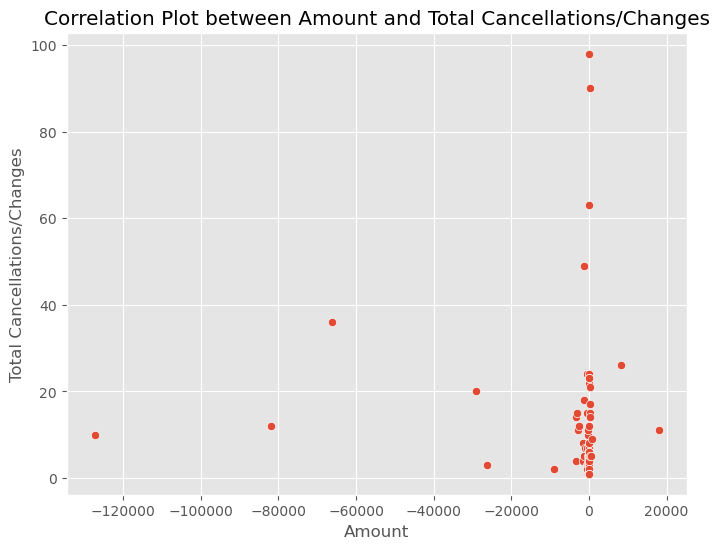

In [747]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'result' is your DataFrame containing 'Amount' and 'total cancellations/changes'
plt.figure(figsize=(8, 6))
sns.scatterplot(data=result, x='Amount', y='total cancellations/changes')
plt.title('Correlation Plot between Amount and Total Cancellations/Changes')
plt.xlabel('Amount')
plt.ylabel('Total Cancellations/Changes')
plt.savefig('output/correlation_plot.png')
plt.show()

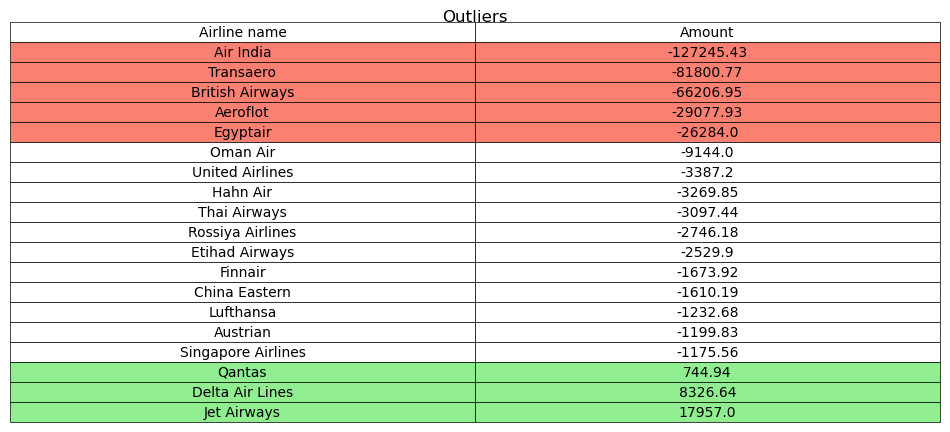

In [748]:
#Finding Outliers

Q1 = result['Amount'].quantile(0.25)
Q3 = result['Amount'].quantile(0.75)
IQR = Q3 - Q1

# Define outliers as values outside 1.5*IQR from the quartiles
outliers = result[(result['Amount'] < Q1 - 1.5 * IQR) | (result['Amount'] > Q3 + 1.5 * IQR)]
outliers = outliers[["Airline name","Amount"]].round(2)

#list of top losses to highlight
df_asc = merged_data.groupby("Airline name")["Amount"].sum().sort_values(ascending=True)
top_losers = df_asc.head(5)
top_losers_list = top_losers.index.tolist()
top_losers_list

#list of top benefits to highlight
df_desc = merged_data.groupby("Airline name")["Amount"].sum().sort_values(ascending=False)
top_winners = df_desc.head(5)
top_winners_list = top_winners.index.tolist()
top_winners_list

fig, ax = plt.subplots(figsize=(10, 5))
ax.axis('off')
table = ax.table(cellText=outliers.values, colLabels=outliers.columns, cellLoc='center', loc='center')

# Highlight the top winners and top losers
for i in range(len(outliers)):
    if outliers.iloc[i]['Airline name'] in top_losers_list:
        for j in range(len(outliers.columns)):
            table[(i+1, j)].set_facecolor('salmon')  # Highlight top losers in salmon color
    elif outliers.iloc[i]['Airline name'] in top_winners_list:
        for j in range(len(outliers.columns)):
            table[(i+1, j)].set_facecolor('lightgreen')  # Highlight top winners in lightgreen color

# Set table properties
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.2)  # Scale the table for better readability
ax.set_title('Outliers', fontsize=12)  # Add a title to the table

plt.savefig('output/outliers_table.png', bbox_inches='tight')
plt.show()

## Benefit/Loss from Cancelled/Changed

### Total Benefits/Loss From Cancelled/Changed For All Airlines

In [749]:
merged_data.Amount.sum().round(2)

-339281.69

## Visualizing the Gains and Losses for all Airlines

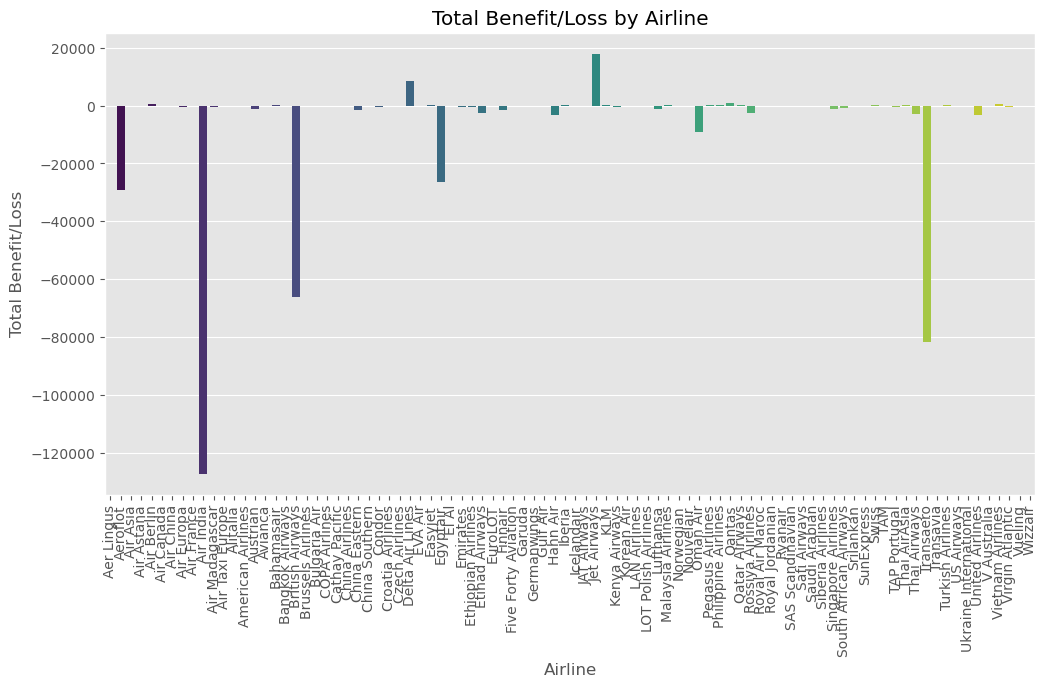

In [750]:
# Calculate the total benefit/loss for each airline
total_benefit_loss_per_airline = merged_data.groupby('Airline name')['Amount'].sum().reset_index()

# Create a bar plot to compare the total benefit/loss amounts among airlines
plt.figure(figsize=(12, 6))
sns.barplot(x='Airline name', y='Amount', data=total_benefit_loss_per_airline, palette='viridis')
plt.title('Total Benefit/Loss by Airline')
plt.xlabel('Airline')
plt.ylabel('Total Benefit/Loss')
plt.xticks(rotation=90)
plt.show()

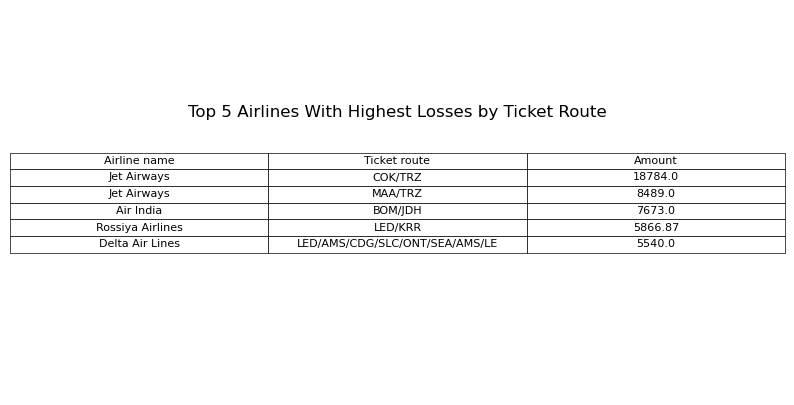

In [751]:
table_data = sorted_data.head(5)

# Create a table plot
fig, ax = plt.subplots(figsize=(10, 5))
ax.axis('off')  # Turn off the axis
ax.table(cellText=table_data.values, colLabels=table_data.columns, cellLoc='center', loc='center')

# Add a title
ax.set_title('Top 5 Airlines With Highest Losses by Ticket Route', fontsize=12, y=.7)

# Save the table as a PNG file
plt.savefig('output/top_5_lowest_amounts_by_route.png', bbox_inches='tight')
plt.show()

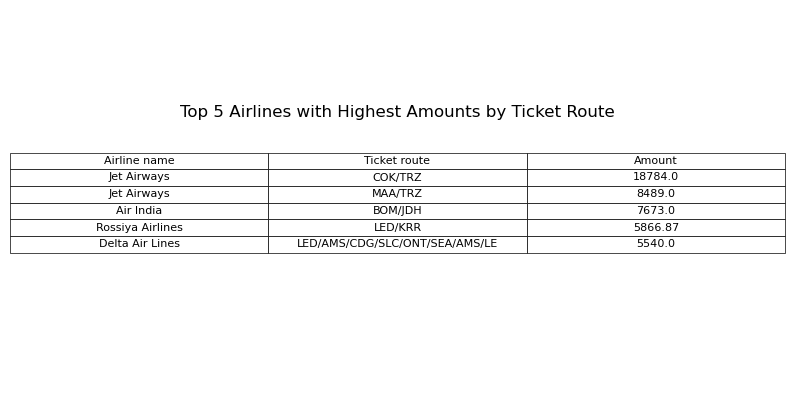

In [752]:
sorted_data = merged_data.groupby(['Airline name', 'Ticket route'])['Amount'].sum().reset_index().sort_values('Amount', ascending=False)

# Select the top 5 highest amounts by route
table_data = sorted_data.head(5)

# Create a table plot
fig, ax = plt.subplots(figsize=(10, 5))
ax.axis('off')  # Turn off the axis
ax.table(cellText=table_data.values, colLabels=table_data.columns, cellLoc='center', loc='center')

# Add a title
ax.set_title('Top 5 Airlines with Highest Amounts by Ticket Route', fontsize=12, y=.7)  # Adjust y value to move the title closer

# Save the table as a PNG file
plt.savefig('output/top_5_highest_amounts_by_route.png', bbox_inches='tight')
plt.show()
